# 분석 과정(예상)

1. 전처리(이상치, 결측치), 데이터 표준화
2. 피어슨 상관분석
3. 회귀분석(단순회귀,다중회귀)
4. 시계열 분석
5. 시각화 

# 패키지, 데이터 준비

In [36]:
from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sb
import numpy as np
from patsy import dmatrix
import sys
import os

# helper.py 모듈 불러로기는 개인 PC의 위치를 사용
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import my_logit, scalling

In [37]:
df=read_excel("세미프로젝트3.xlsx")
df

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


In [38]:
#원본 데이터 유지하기 위해 카피본 생성
df1=df.copy()

# 반복문으로 데이터의 수치가 0인값, 0이 아닌 값을 확인

컬럼 유지, 추가, 제거 여부를 결정

In [39]:
for column in df1.columns:
    zero_count = df1.loc[df1[column] == 0].shape[0]
    number_count = df1.loc[df1[column] != 0].shape[0]
    print('0 개수 :',{column : zero_count})
    print('0 아닌 수 :',{column : number_count})
    print('-'*30)

0 개수 : {'총생활비': 0}
0 아닌 수 : {'총생활비': 7865}
------------------------------
0 개수 : {'이자_배당금_연간소득': 5489}
0 아닌 수 : {'이자_배당금_연간소득': 2376}
------------------------------
0 개수 : {'임대료_연간소득': 6707}
0 아닌 수 : {'임대료_연간소득': 1158}
------------------------------
0 개수 : {'기타_소득': 1439}
0 아닌 수 : {'기타_소득': 6426}
------------------------------
0 개수 : {'세금환급금': 6275}
0 아닌 수 : {'세금환급금': 1590}
------------------------------
0 개수 : {'금융기관대출': 5500}
0 아닌 수 : {'금융기관대출': 2365}
------------------------------
0 개수 : {'주거관련_부채의_이자': 6414}
0 아닌 수 : {'주거관련_부채의_이자': 1451}
------------------------------
0 개수 : {'주택관련_부채액': 5342}
0 아닌 수 : {'주택관련_부채액': 2523}
------------------------------
0 개수 : {'공적연금_연간소득': 4777}
0 아닌 수 : {'공적연금_연간소득': 3088}
------------------------------


# `이상치/결측치` 확인 및 처리

- 종속변수
> 총생활비

- 독립변수
> '이자_배당금_연간소득','임대료_연간소득','기타_소득','세금환급금'</br>
> '금융기관대출', '주거관련_부채의_이자','주택관련_부채액','공적연금_연간소득'

- 불로소득에 포함되는 변수
>이자_배당금_연간소득, 임대료_연간소득, 공적연금_연간소득, 세금환급금

# 그래프 초기화

In [40]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

In [41]:
df1.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0


# 결측치, 이상치 확인

이상치는 그래프를 사용해 확인 후 처리 범위를 결정

## 결측치 확인

In [42]:
# 해당 데이터에서 한번에 결측치 조회
df1.isna().sum()

총생활비              0
이자_배당금_연간소득       0
임대료_연간소득          0
기타_소득             0
세금환급금             0
금융기관대출            0
주거관련_부채의_이자       0
주택관련_부채액       1079
공적연금_연간소득         0
dtype: int64

### 확인 결과
주택관련_부채액 결측치 1079건 수치값 `0`으로 가정하고 대체

In [43]:
re_df1=df1.fillna(value=0)
re_df1

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


### 결측치 처리 확인

In [44]:
re_df1.isna().sum()

총생활비           0
이자_배당금_연간소득    0
임대료_연간소득       0
기타_소득          0
세금환급금          0
금융기관대출         0
주거관련_부채의_이자    0
주택관련_부채액       0
공적연금_연간소득      0
dtype: int64

## 종속/독립변수 상관관계 및 이상치 확인

귀무가설: 총생활비와 y값의 상관이 없다.<br>
대립가설: 총생활비는 y값과 상관이 있다.

### 각 컬럼 별 이상치 찾기(1)

반복문과 서브플롯을 사용해 간단히 생성 (regplot)

In [45]:
# 그래프 생성을 위해 컬럼 이름, 길이 확인
re_df1.columns
len(re_df1.columns)

9

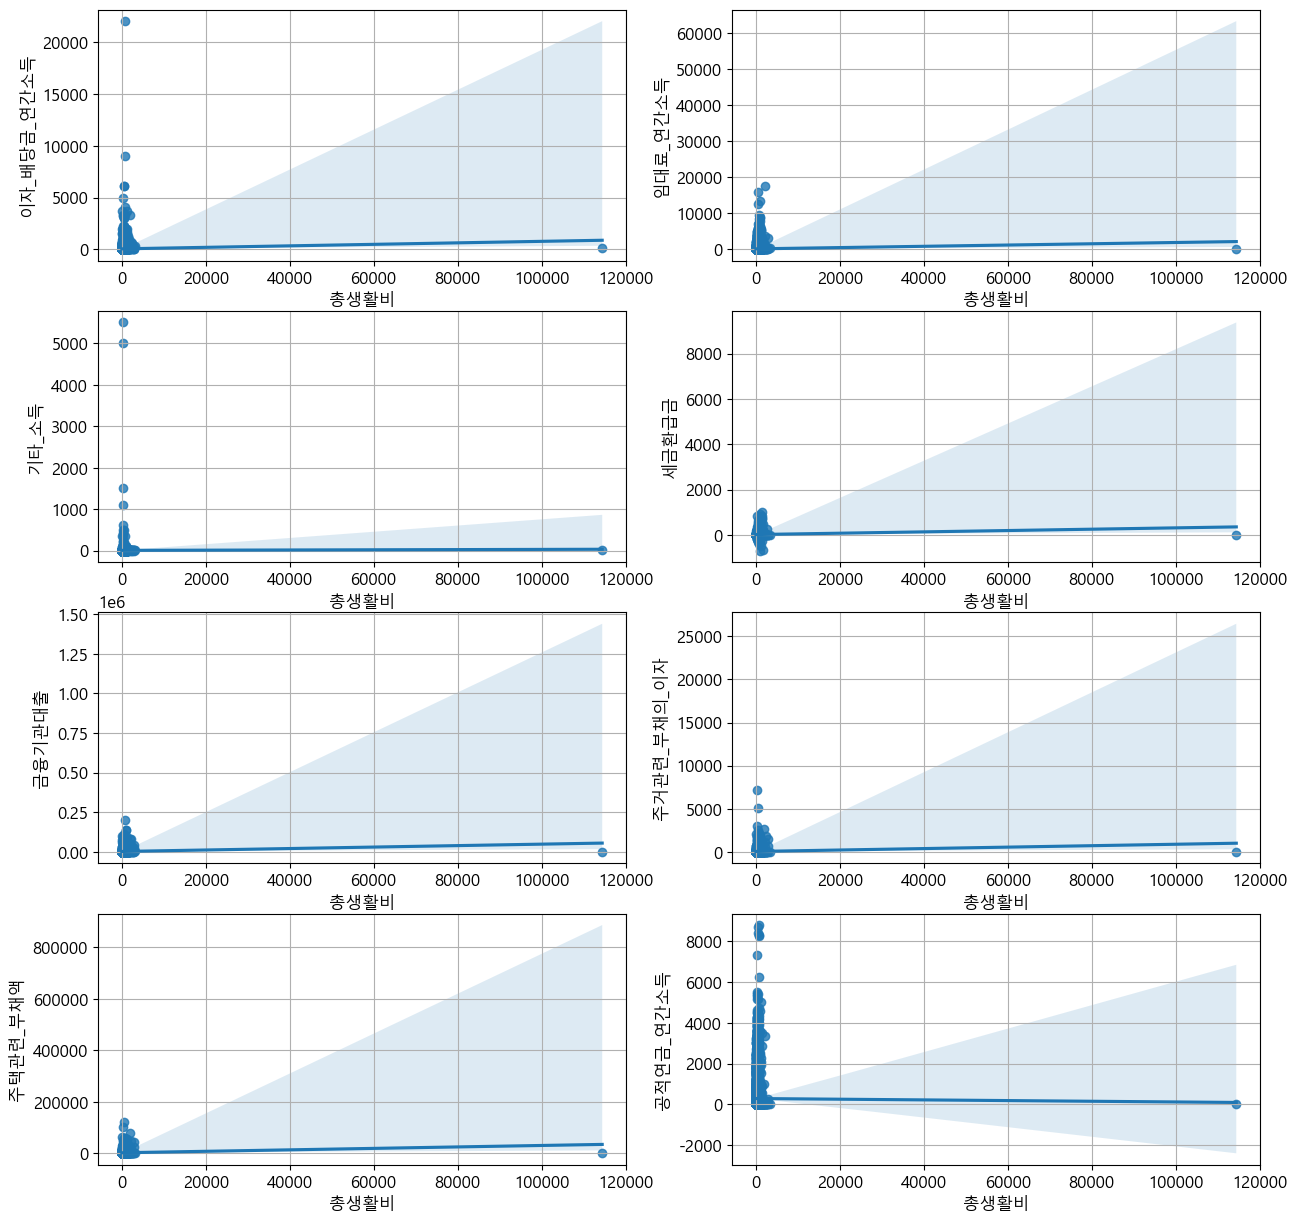

In [46]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
# 현재 종속변수-독립변수의 상관관계만 필요
columns = list(re_df1.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=re_df1, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid()

plt.show()
plt.close()

## 각 컬럼 별 이상치 찾기(2)

반복문과 서브플롯을 사용해 간단히 생성 (boxplot)

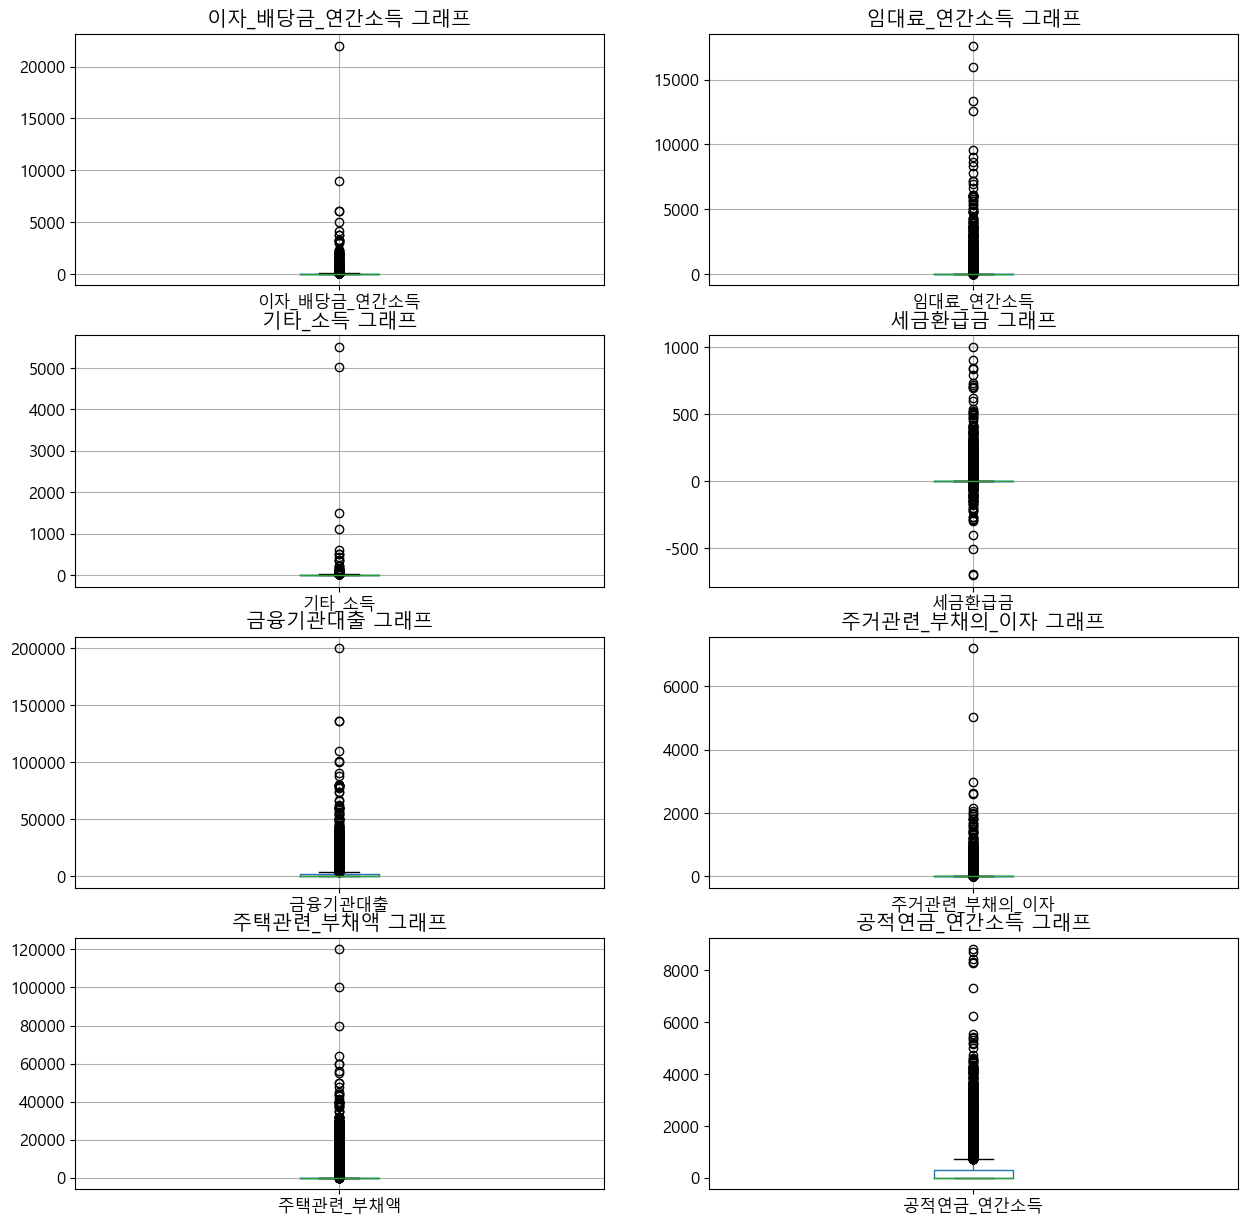

In [47]:
# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    re_df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid()
plt.show()

### regplot, boxplot 조회 결과

- `x값`으로 넣을 `종속변수`(총생활비)에서 1건만 비정상으로 높은 수치 확인되어 제거 후 진행

- `y값`으로 넣을 `독립변수`들 중 `이상치가 각 컬럼에서 발견`되어 프로젝트 참가자들 `주관적 판단하에 제거 범위를 결정`

- 이자_배당금_연간소득 상위이상치 2건, 임대료_연간소득 상위이상치 4건,기타_소득 상위이상치 4건</br>

- 주택관련_부채액 상위이상치 3건, 공적연금_연간소득 상위이상치 7건

- 세금환급금 상위이상치 8건, 금융기관대출 상위이상치 2건, 주거관련_부채의_이자 상위이상치 4건

- 종속변수와 독립변수를 포함해서 `총 35건의 데이터를 제거`

### 이상치 행 제거 후 조회

In [48]:
df2=re_df1.query('(총생활비 < 5000) and (이자_배당금_연간소득 < 7000) and (임대료_연간소득 < 11000) and\
                 (기타_소득 < 1000) and (주택관련_부채액 <75000) and (공적연금_연간소득 <6000) and \
                 (세금환급금 > -500 and 세금환급금 < 750)\
                 and (금융기관대출 < 125000) and (주거관련_부채의_이자 < 2500)')
df2

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


### 이상치 데이터 제거후 regplot으로 그래프 재확인하기

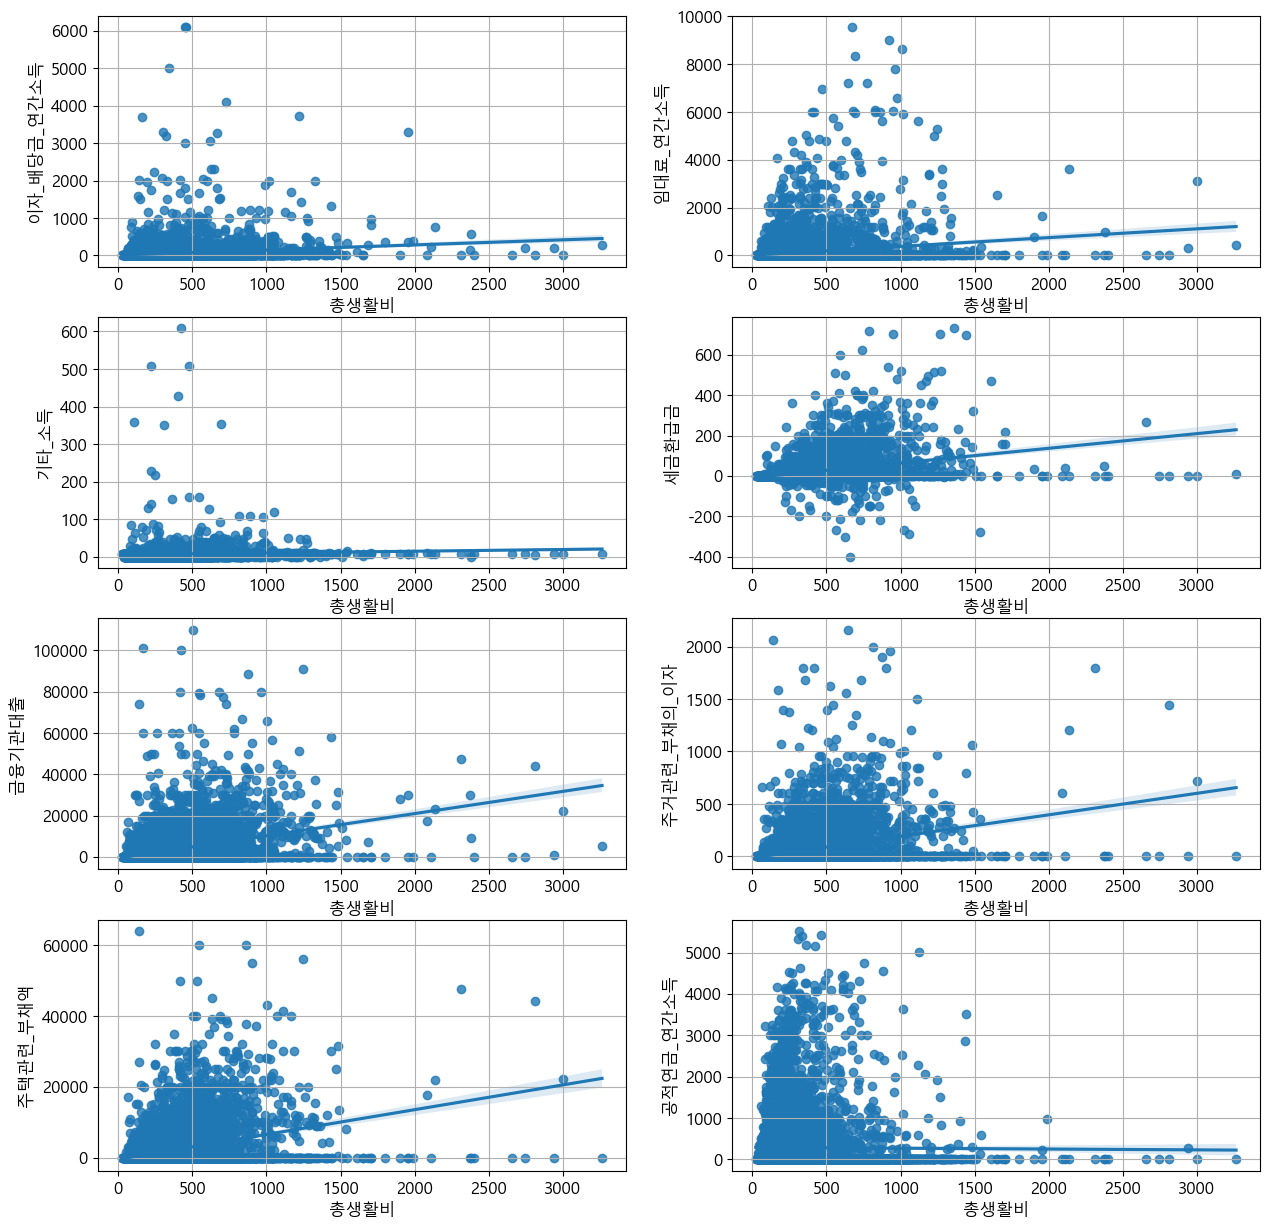

In [49]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(df2.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=df2, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid()

plt.show()
plt.close()

#### 결과
이상치 제거 이전과 비교해 비교적 데이터가 고르게 분포한다고 판다.

### 반복문을 사용한 피어슨 상관분석 진행

In [50]:
# 독립변수 리스트
columns = list(df2.columns)[1:]
# 종속변수
dependent_variable = '총생활비'
# 결과 저장을 위한 빈 리스트 선언
r = []
p = []

for c in columns:
    # 피어슨 상관분석 수행
    corr, p_val = stats.pearsonr(df2[dependent_variable], df2[c])
    # 결과를 리스트에 저장
    r.append(corr)
    p.append(p_val)
    # 결과 출력
    print(f"'총생활비'와 '{c}'의 피어슨 분석\n r: {corr}, p: {p_val}\n")

'총생활비'와 '이자_배당금_연간소득'의 피어슨 분석
 r: 0.16314738297932818, p: 7.638725754080436e-48

'총생활비'와 '임대료_연간소득'의 피어슨 분석
 r: 0.17811669108795505, p: 7.956642651475088e-57

'총생활비'와 '기타_소득'의 피어슨 분석
 r: 0.07896518600206892, p: 2.6107745641463067e-12

'총생활비'와 '세금환급금'의 피어슨 분석
 r: 0.35837229167487744, p: 5.522347059288661e-236

'총생활비'와 '금융기관대출'의 피어슨 분석
 r: 0.38025485911675905, p: 7.898255190936739e-268

'총생활비'와 '주거관련_부채의_이자'의 피어슨 분석
 r: 0.3409581757096795, p: 2.2417650986055645e-212

'총생활비'와 '주택관련_부채액'의 피어슨 분석
 r: 0.3627198847176846, p: 4.089108192874763e-242

'총생활비'와 '공적연금_연간소득'의 피어슨 분석
 r: -0.008377261997174455, p: 0.45858682790782124



#### 결과

피어슨 상관분석 결과 p-value를 만족하는 것을 확인, 해당 데이터를 사용해 분석을 진행하기로 결정.

분석 진행을 위해 표준화(스케일링)이 필요하다고 판단.

In [51]:
corr = df2.corr(method='pearson')
corr

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
총생활비,1.000000,0.163147,0.178117,0.078965,0.358372,0.380255,0.340958,0.362720,-0.008377
이자_배당금_연간소득,0.163147,1.000000,0.107434,0.019644,0.057853,0.050670,0.015769,0.024315,0.073351
임대료_연간소득,0.178117,0.107434,1.000000,0.017712,0.015072,0.188534,0.081602,0.070473,0.094136
기타_소득,0.078965,0.019644,0.017712,1.000000,0.049301,0.029858,0.016758,0.027468,0.001033
세금환급금,0.358372,0.057853,0.015072,0.049301,1.000000,0.199542,0.194347,0.226202,-0.085098
금융기관대출,0.380255,0.050670,0.188534,0.029858,0.199542,1.000000,0.667216,0.726963,-0.058325
주거관련_부채의_이자,0.340958,0.015769,0.081602,0.016758,0.194347,0.667216,1.000000,0.847931,-0.061578
주택관련_부채액,0.362720,0.024315,0.070473,0.027468,0.226202,0.726963,0.847931,1.000000,-0.075824
공적연금_연간소득,-0.008377,0.073351,0.094136,0.001033,-0.085098,-0.058325,-0.061578,-0.075824,1.000000


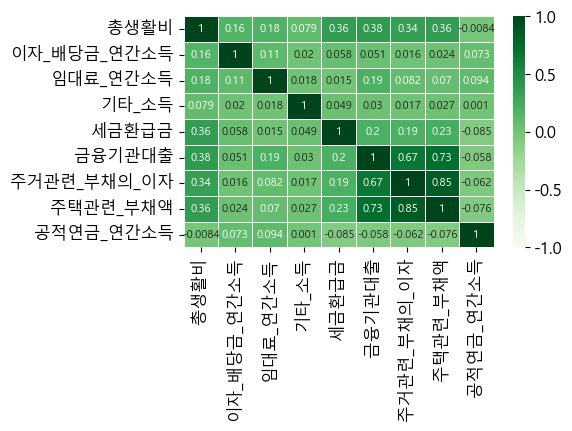

In [52]:
plt.rcParams["figure.figsize"] = (5,3)

sb.heatmap(corr,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상(Greys,Purples,Blues,Greens,Oranges,Reds,OrRd,PuRd,RdPu,BuPu,GnBu,PuBu,YlGnBu,PuBuGn,BuGn,YlGn)
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
           linewidths=.5, #구분선 굵기
           annot_kws={"size": 8}  # 글자 크기 조정
)

plt.show()
plt.close()

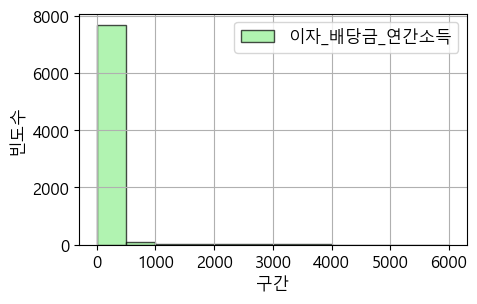

In [56]:
# 히스토그램 구간 설정
bin_edges = [0, 500, 1000, 2000, 3000, 4000, 5000, 6000]
bin_labels = [f'{bin_edges[i]}-{bin_edges[i+1]}' for i in range(len(bin_edges)-1)]

# 히스토그램 그리기
plt.hist(df2['이자_배당금_연간소득'], bins=bin_edges, alpha=0.7, color='lightgreen', edgecolor='black', label='이자_배당금_연간소득')
plt.xlabel('구간')
plt.ylabel('빈도수')
plt.legend()
plt.grid()
plt.show()

In [55]:
# # 파이차트 그리기
# plt.figure(figsize=(6, 6))
# sum_by_categories = df2[['총생활비', '이자_배당금_연간소득']].sum()
# labels = ['이자_배당금_연간소득']
# plt.pie(sum_by_categories, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title('총생활비와 이자_배당금_연간소득 비율')
# plt.show()